## Rite of passage machine-learning project: Yet another stock picker

Stock market is often a gateway to understanding the promises and challenges of machine learning (ML) -- datasets are easy to come by, and you can think of a million ways to slice and dice the data. And then there is the lure of figuring it all out and making money when you are at it! The core of the stock market data is the stock prices, recorded at various intervals, and the volumes of stocks traded. We need to understand how we can handle the time series data to be able to make sense of this problem.


### Dealing with time series data:

From a more technical perspective, this notebook shows a way to analyze time-series data using ML algorithms for a specific class of problems. Time series data are ubiquitous, and usually we want to forecast future values based on the past values. Say, we want to find out the future trend in stock prices (going up or down) of a certain stock, or the high and low temperature next month based on the historical weather data. How do we think about this problem when we have many time series, and we want to extract general trends? Extending the weather prediction analogy, we may be interested in finding out if the average temperature next month, when we take the entire planet into account, is going to be a little bit higher than the same month last year, irrespective of their individual variations.

When we are trying to compare many time series, it is useful to construct features out of the time series under investigation, and treat them as any other feature associated with each item.


### Connection with learning analytics:

What brought me to this problem is the need to analyze time-stamped activities of users on an online learning platform. Learner activities have some predictable patterns (e.g., activity spikes before an exam), as well as some less predictable signatures: will an advance learner spend more time on an ungraded activity (becuase the learner takes everything very seriously), or, less time, becuase the learner is busy and has no time to spare? The answer depends on the context, and studying such time-stamped data tells us a lot about the learners and the context. 

Analyzing time series data is a vast field, and the right approach depends on the problem at hand. The rest of the notebook is developed in a way that it's possible to transfer our understanding from the stock market toy problem to learners' timestamped data.

*DISCLAIMER: You won't be able to make any money off the processes shown here in this notebook. But you probably guessed that from the get go!*

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import os
from pathlib import Path
import json, time
import urllib.request, urllib.error
import matplotlib.pyplot as plt # this is used for the plot the graph 

pd.set_option('display.max_columns', None) # Display any number of columns

#Import sklearn packages -- you don't need all of them for this notebook, 
#but you may want to find out what they do
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold, train_test_split,\
GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures # for normalization
from sklearn.pipeline import make_pipeline # pipeline making
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif, RFE,\
RFECV
from sklearn.decomposition import PCA
from sklearn import metrics, linear_model, ensemble, neighbors, tree, svm, neural_network,\
naive_bayes, isotonic# for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score, precision_recall_fscore_support

#statsmodel packages:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
import statsmodels as sm
import statsmodels.api as smapi



In [3]:
#For plotting
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.plotly as py

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

### Datasets

In this notebook we would take a look at the daily stock prices (open, high, low and close, in USD, and the total volume of stocks traded -- also called OHLCV data) for a number of popular stocks. You can get these datasets from https://finance.yahoo.com/, for example. I have included a handful of these files in the data folder.

Below we read in one dataset and inspect its tail.

In [4]:
#Read in data
msft_df = pd.read_csv('data/MSFT.csv')
msft_df.tail()

Date        Open        High         Low       Close   Adj Close  \
7278  2018-11-16  107.080002  108.879997  106.800003  108.290001  108.290001   
7279  2018-11-19  108.269997  108.559998  103.550003  104.620003  104.620003   
7280  2018-11-20  101.800003  102.970001   99.349998  101.709999  101.709999   
7281  2018-11-21  103.599998  104.430000  102.239998  103.110001  103.110001   
7282  2018-11-23  102.169998  103.809998  102.000000  103.070000  103.070000   

        Volume  
7278  33502100  
7279  44773900  
7280  64052500  
7281  28130600  
7282  13823100

### Problem description:

Let's say, we want to find out if there is a discernible trend in how prices fluctuate on a day-to-day basis, and if we can generate a signal around the closing time (4pm Eastern time) regarding next day's price trends.

We hypothesize that if there were to be a general trend, we may be able to discover that by analyzing a lot of different stock prices over a length of time. Once we are able to find a general enough model, we could try to apply that on different stock prices everyday, and see which stocks match this signal.

*Below we show the list of stocks included in the data folder.*

In [6]:
all_assets = [item.split('.')[0] for item in os.listdir('data')]

all_assets

['BA',
 'V',
 'F',
 'AMZN',
 'GM',
 'MMM',
 'MSFT',
 'AMD',
 'GE',
 'TSLA',
 'GOOG',
 'AAPL',
 'NBEV']

### Time series: autocorrelation

Wikipedia (https://en.wikipedia.org/wiki/Autocorrelation) is a good place to start for figuring out autocorrelation -- often a starting point for time series investigation.  For periodic time series data, we find peaks corresponding to periodicities (as the values at those periods are highly correlated). Conversely, a series of random numbers have very little correlation at any interval.

We check this phenomenon with a series of 10k (quasi-)random numbers distributed normally.

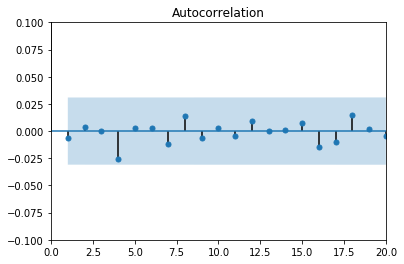

In [69]:
gauss = np.random.normal(size=10000)
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html#numpy.random.normal
lag1 = 20

plot_acf(gauss,lags=lag1, alpha=0.002)
#https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html

plt.axis([0.0,lag1,-0.1,0.1])
plt.show()

The blue band in the plot is the confidence interval (as set by the keyword alpha). 0.002 corresponds to a CI of 99.8% -- which is what our randomly distribute data occupy.

This is a reasonably strict CI, so if we have stock price fluctuations showing stronger peaks at any interval, we might want to investigate if we can extract any trend from that.

#### Absolute stock prices vs. change in stock prices:

This is probably obvious, but I'll state this anyway. Absolute stock prices are fairly highly correlated, and that information is not useful to us. We want to see if the **change** in the prices have any pattern. For this, we look at the percentage change in the daily high prices for MSFT.


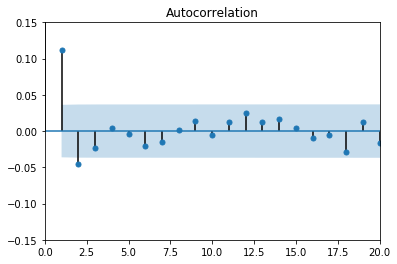

In [71]:
lag1 = 20
ts = msft_df['High'].pct_change()[1:] #the first value is NaN -- we ignore that value
plot_acf(ts, lags=100, alpha=0.002)
plt.axis([0,lag1,-0.15,0.15])
plt.show()

#### Very short-range autocorrelation:

So we see that the price change of the daily high prices do have some autocorrelation with the next value, and possibly some negative correlation with the prices the day after. Beyond that, it's hard to infer anything statistically significant.

What we see is a very short-range correlation, implying that there is possibly little value in taking into account prices that are from further ago. Plus, we would like to keep this notebook simple as the focus is on the process than the results.

#### Feature engineering:

Even if we take into account the prices from the previous few days, there are many "features" that one can construct by combining these prices in different ways. Again, we would like to keep this whole analysis short and sweet, and here is the description of the features we would study:

1. 'dv': % change in today's trading volume compared to yesterday's
2. 'dmu': % change in today's mean OHLC price compared to yesterday's
3. 'dmu_1': % change in yesterday's mean OHLC price compared to the day before yesterday's -- this is where we are going beyond just yesterday's numbers
4. 'hh1': % change in today's highest price compared to yesterday's
5. 'hc1': % change in today's highest price compared to yesterday's closing price
6. 'oc1': % change in today's opening price compared to yesterday's closing price
7. 'lc1': % change in today's lowest price compared to yesterday's closing price
8. 'cc1': % change in today's closing price compared to yesterday's closing price


#### What to predict?

We might want to predict the next trading day's high price around the closing price of today. We call this:
**'hc1_next'**

#### Why did we choose this set of features?

Mainly for demonstration purposes. For a real problem, you might want to select a more exhaustive set of features, and then use methods like PCA to reduce the feature dimensions. You might also inlcude other factors such as the day of the week, or the nature of the company as features, and test if those selections have any measurable impact on your prediction. Feature engineering is somewhat like magic, after all.


#### Read in all the data, and pre-process them for training and testing:

We read in all the included data in a loop, and construct the features mentioned above. We make sure
1. to ignore rows with NaN/infinity values,
2. that each row has features that are available "now", while the value to be predicted /classified is from the future,
3. to randomize all the rows so no special pattern corresponding to one company's stock going up/down could influence our model, and
4. to convert all the important numbers to percentages so the absolute prices/volumes of any stock has no effect on our model.

In [82]:
#What we want is day-to-day variations, rather than absolute prices. So we convert them all.
def return_prepared_df():
    model_cols = ['dv', 'dmu', 'dmu_1', 'hh1', 'hc1', 'oc1', 'lc1', 'cc1', 'hc1_next']
    df_list = []
    
    for tck in all_assets:
        temp_df = pd.read_csv('data/{}.csv'.format(tck))
        temp_df['tck'] = tck #introduce a column with the ticker, in case we want to analyze/train by that...

        #calculate daily OHLC mean
        temp_df['mean'] = (temp_df['Open']+temp_df['High']+temp_df['Low']+temp_df['Close'])/4.0


        temp_df['close_1'] = temp_df['Close'].shift()        #The previous trading day's closing price
        temp_df['open_1'] = temp_df['Open'].shift()        #The previous trading day's opening price

        temp_df['dv'] = 100.0*temp_df['High'].pct_change() #% change in volume traded compared to last trading
        #day. Notice that just pct_change() will give you the fraction, and the not the percentage itself.
        temp_df['dmu'] = 100.0*temp_df['mean'].pct_change() #% change in mean OHLC prices from the last trading
        #day
        temp_df['dmu_1'] = temp_df['dmu'].shift()#% change in mean OHLC price yesterday wrt the day before
        
        temp_df['hh1'] = 100.0*temp_df['High'].pct_change()      #% change in high price compared to yesterday's  

        temp_df['hc1'] = 100.0*(temp_df['High'] - temp_df['close_1'])/temp_df['close_1']
        temp_df['oc1'] = 100.0*(temp_df['Open'] - temp_df['close_1'])/temp_df['close_1']
        temp_df['lc1'] = 100.0*(temp_df['Low'] - temp_df['close_1'])/temp_df['close_1']
        temp_df['cc1'] = 100.0*(temp_df['Close'] - temp_df['close_1'])/temp_df['close_1']
        #Please refer to the feature definitions described above to unpack the 4 lines above
        

        #This is where we are including the next days' return: % change of high values tomorrow compared to
        #the closing price today.
        temp_df['hc1_next'] = temp_df['hc1'].shift(-1)

        #We add all these dataframes with the added features into a list...
        df_list.append(temp_df)
        
        
    #...and then concatenate them into one big list    
    new_df = pd.concat(df_list, axis=0, ignore_index=True)


    #drop any row with NaN and inf values
    with pd.option_context('mode.use_inf_as_null', True):
        new_df = new_df.dropna(how='any')
    
    #Choose only the columns necessary for training/testing
    #Also, randomize the rows and reset in index
    ret_df = new_df[model_cols].sample(frac=1).reset_index(drop=True)
    
    #Remember that the last element in the model_cols list is the quantity to be predicted. We call this 'y_reg'
    y_reg = ret_df['hc1_next'].values.astype(np.float)
    #The feature are all but the last element of the model_cols list
    X = ret_df[model_cols[:-1]].values.astype(np.float)
    #return these arrays and the dataframe
    return X, y_reg, ret_df

In [83]:
#Call this function, and inspect that the order of features and rows are what you expect
X, y_reg, ret_df = return_prepared_df()
print('X:',(X))
print('y_reg:',(y_reg))
ret_df.tail()

X: [[ 2.12271921  2.14051817  0.50944431 ...  1.7426514   0.96468341
   2.34946642]
 [ 0.32921811  2.1141649  -0.52576236 ...  0.91973244 -0.50167224
   1.50501672]
 [ 2.76750255  3.75741568  2.00065476 ...  1.09455676  0.64831779
   2.03755588]
 ...
 [-0.15748031 -1.10715698  0.00988441 ...  0.63492063 -2.3015873
  -1.98412698]
 [ 0.4737215   0.16140163 -0.96536051 ...  0.05678429 -0.10496164
   1.18046291]
 [-0.61618202 -0.6421148   0.01792156 ...  0.01195268 -1.44598351
  -1.23087715]]
y_reg: [ 0.01520523 -0.57660626  0.         ...  1.05263158 -0.00170134
  0.02419359]


dv       dmu     dmu_1       hh1       hc1       oc1       lc1  \
67467 -5.232485 -6.332833 -0.293667 -5.232485 -2.976133 -2.976133 -7.738133   
67468  0.966230 -0.122692  2.515731  0.966230  3.465345  0.000000 -2.475310   
67469 -0.157480 -1.107157  0.009884 -0.157480  0.634921  0.634921 -2.301587   
67470  0.473722  0.161402 -0.965361  0.473722  1.462674  0.056784 -0.104962   
67471 -0.616182 -0.642115  0.017922 -0.616182  0.227059  0.011953 -1.445984   

            cc1  hc1_next  
67467 -7.738133  1.935505  
67468  1.980182  7.766927  
67469 -1.984127  1.052632  
67470  1.180463 -0.001701  
67471 -1.230877  0.024194

#### Regression problem, but...

We are training our model with values from a continuous distribution, and this is a regression problem. However, just to be able to show a few more methods (perhaps importnat elsewhere!), we cast this as a classification problem. This is artificial, but useful.

In [84]:
#Say, you want to find out cases where hc1_next is > 4%
thresh = 4.0
y_clf = np.where(y_reg>thresh, 1, 0)
print('y_clf:',y_clf)

y_clf: [0 0 0 ... 0 0 0]


#### A simple beginning:

For quick tests, it's very useful to be able to easily split the data into a random training/test fraction (in our case we already randomized the rows) -- we use the train_test_split function from sklearn.model_selection for that purpose. Notice how we can specify the fraction of the test dat size. Since this step involves generating random numbers, choosing a random state helps us reproducing our numbers later.

Also, we scale the feature set so no single feature is a priori more important than any other feature:
https://en.wikipedia.org/wiki/Feature_scaling

In [86]:
#try standardizing feature ranges:
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler_ = StandardScaler()
X_ = scaler_.fit_transform(X)

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X_, y_clf, test_size=0.2, random_state=0)

### Quick and dirty training/testing with gradient boosting classifier:

1. Instantiate the classifier
2. Fit with the training data
3. Test on the test data

In [87]:
kwargs = {}

clf_0 = ensemble.GradientBoostingClassifier(**kwargs)
clf_0.fit(X_train,y_train)
y_pred = clf_0.predict(X_test)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12406
           1       0.48      0.09      0.15      1089

   micro avg       0.92      0.92      0.92     13495
   macro avg       0.70      0.54      0.56     13495
weighted avg       0.89      0.92      0.89     13495



We see that the results for the class "1" is way worse than the class "0". Unfortunately that's the class we would like to predict accurately. Notice that it has a particularly terrrible recall score (TP/(TP + FN)), meaning that we have a high degree of false negatives -- i.e., predicting that the price wouldn't go up over 4% when it actually does.

Sometimes the problem at hand determines what score is of critical importance. For us, we care more about a high precision (correctly predicting the cases when the prices go up), than a high recall, if we have to choose.

### Cross validation:

We created our model by dividing our dataset into the training and the test dataset, would the classification scores change if we considered different slices of the dataset for training and testing? To test that, we split the dataset in slices, and perform the same analysis multiple times on thse slices (and then take average if we want):

In [88]:
#Cross-validation
X = X_ #using standardized feature sets:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=4, **kwargs):
    #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=0)
    for train_index, test_index in skf.split(X, y_clf):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_clf[train_index], y_clf[test_index]    

        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        print(metrics.classification_report(y_test, y_pred))
        #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
    return y_pred

In [89]:
#Although we stick to just one classified, feel free to try out ther classifiers. None does a spectacular job
#in this case.
clf_list = [#('PassiveAggressive',linear_model.PassiveAggressiveClassifier),
            ('GradientBoosting', ensemble.GradientBoostingClassifier),
            #('SVM',svm.SVC),
            #('RandomForest',ensemble.RandomForestClassifier),
            #('KNN',neighbors.KNeighborsClassifier),
            #('LogisticRegression',linear_model.LogisticRegression),
            #('naive_bayes.GaussianNB', naive_bayes.GaussianNB),
            #('MLPclassifier',neural_network.MLPClassifier)
]
t1 = time.time()
for clf in clf_list:
    print(clf[0]+':')
    print(' {}\n'.format(stratified_cv(X, y_clf,clf[1])))  
t2 = time.time() 
print('It took {}s to run this cell'.format(round(t2 - t1,3)))

GradientBoosting:
TRAIN: [    1     2     3 ... 67468 67470 67471] TEST: [    0     6    14 ... 67462 67466 67469]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     15468
           1       0.56      0.08      0.15      1401

   micro avg       0.92      0.92      0.92     16869
   macro avg       0.74      0.54      0.55     16869
weighted avg       0.89      0.92      0.89     16869

TRAIN: [    0     2     5 ... 67466 67468 67469] TEST: [    1     3     4 ... 67467 67470 67471]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     15468
           1       0.55      0.08      0.13      1400

   micro avg       0.92      0.92      0.92     16868
   macro avg       0.74      0.54      0.55     16868
weighted avg       0.89      0.92      0.89     16868

TRAIN: [    0     1     3 ... 67469 67470 67471] TEST: [    2     7     8 ... 67450 67458 67468]
              precision    recall  f1

### Back to regression:

As we stated earlier, this is a regression problem as constructed, and the classification angle was a detour. So we get back to using regressors, and we use 2 kinds: random forest regeressor and linear regressor. We train the models with about 60% of the data and test the models on the remained of the data. We also print out a number of evalutation metrics:

In [23]:
#Use 2 different regressors:
regr_list = [('Random Forest',ensemble.RandomForestRegressor),
             ('Linear regression', linear_model.LinearRegression)]

for regr_class in regr_list:
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_reg,
                                                    test_size=0.4,
                                                    random_state=0)

    parameters = {}
    reg = regr_class[1](**parameters)

    reg.fit(X_train, y_train)
    predictions = reg.predict(X_test)    

    rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
    mae = metrics.mean_absolute_error(y_test, predictions)
    medae = metrics.median_absolute_error(y_test, predictions)
    exp_var = metrics.explained_variance_score(y_test, predictions)
    print('Regressor: {}'.format(regr_class[0]))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Median Absolute Error: {:.3f}'.format(medae))
    print('Explained variance(r2_score): {:.3f}'.format(exp_var))
    print('========================\n')

/Users/anindyaroy/Sites/fun/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Regressor: Random Forest
Root Mean Square Error: 2.402
Mean Absolute Error: 1.400
Median Absolute Error: 0.897
Explained variance(r2_score): 0.004

Regressor: Linear regression
Root Mean Square Error: 2.226
Mean Absolute Error: 1.263
Median Absolute Error: 0.794
Explained variance(r2_score): 0.144



### Which regressor is better?

It seems that the linear regressor is performing better than RF, but even then we have only about 14% of the variance in our data explained by this model.

### Plot the predicted vs. test hc1_next values:

If we could generate a good model, the plot of the predicted values vs. the test data will be a straight line with a 45${^\circ}$ slope. What we see below is far from that!


In [28]:

trace0 = go.Scatter(x = predictions, y = y_reg, mode='markers')

data = [trace0]

layout = go.Layout(
    xaxis=dict(
        title='Predicted values in hc1(%) return',
        #autorange=True
        range = [4,10]

    ),
    yaxis=dict(
        title='Actual values in hc1(%) return',       
        #autorange=True
        range = [-20,20]
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)


### Take-home messages:

The predictions here are terrible, but they are still mostly positive. However, it's *very hard* to translate that sort of insight into a money-making venture, mostly because it's hard to know **when** you reach the high price, and a host of other factors.

However, such details should not deter you from trying to tame the stock market, or learning analytics! Have fun, and feel free to reach out if you have questions.

**Thanks in advance for catching any mistakes in this analysis!**